In [2]:
from IPython.display import clear_output

In [3]:
!pip install pytorch-lightning
clear_output()

In [4]:
import os
import torch.optim as optim
from pathlib import Path
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Dataset

In [199]:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class MangaDataset(Dataset):
    """Road  dataset"""

    def __init__(self, data_dir: str = 'data', im_size = (64, 64), transform = None):
        """
        data_dir: str - path to images directory
        transform: tochvision.transforms - transforms to be used on images
        """
        if transform:
            self.transform = transforms.Compose([
                transforms.Resize(im_size),
                transforms.ToTensor(),
                transform
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(im_size),
                transforms.ToTensor(),
            ])
        self.dataset = list(map(str, Path(data_dir).rglob("*.jpg")))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Getting index
        if torch.is_tensor(idx):
            idx = idx.tolist()
        im_path = self.dataset[idx]
        # Opening and transforming the image
        with Image.open(im_path) as im:
            gray = ImageOps.grayscale(im)
            return self.transform(gray)

# Data Wrapping

In [201]:
!unzip drive/MyDrive/data.zip
clear_output()

In [202]:
# folder with data
dir = 'data'

# parameters of data
batch_size  = 64
train_ratio = 0.8

# getting all pieces of data together (test + train)
data_full = MangaDataset(dir)

# splitting the data on train and test
train_len = int(len(data_full) * train_ratio)
test_len  = len(data_full) - train_len
train_samples, test_samples = random_split(data_full, [train_len, test_len])

# wrapping data into dataloaders
# NB lists are used as transforms became a bottleneck during the training process
# and calculating transforms each time has become expensive
train_data = list(DataLoader(train_samples, batch_size=batch_size))
test_data  = list(DataLoader(test_samples,  batch_size=batch_size))

# Model

In [203]:
class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)

# https://github.com/1Konny/Beta-VAE/blob/master/model.py
class MangaModel(nn.Module):
    def __init__(self, n_size):
        super().__init__()
        self.n_size = n_size
        # Encoder model
        self.encoder = torch.nn.Sequential( # shape (1, 64, 64)
            torch.nn.Conv2d(1, 32, 4, stride=2, padding=1), # (32, 32, 32)
            torch.nn.ReLU(), 
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 32, 4, stride=2, padding=1), # (32, 16, 16)
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Dropout2d(),
            torch.nn.Conv2d(32, 64, 4, stride=2, padding=1), # (64, 8, 8)
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(64, 64, 4, stride=2, padding=1), # (64, 4, 4)
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(64, 256, 4, stride=1), # (256, 1, 1)
            torch.nn.ReLU(),
            torch.nn.Dropout2d(),
            torch.nn.BatchNorm2d(256),
            torch.nn.Flatten(),
            torch.nn.Linear(256, n_size)
        )
        # Decoder model
        self.decoder = torch.nn.Sequential( # shape (64, 28, 28)
            torch.nn.Linear(n_size, 256),
            View((-1, 256, 1, 1)),
            torch.nn.ConvTranspose2d(256, 64, 4, stride=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Dropout2d(),
            torch.nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Dropout2d(),
            torch.nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        # mu, sigma = x[:, :self.n_size], x[:, self.n_size:]
        # x = self.sample(mu, sigma)
        out = self.decoder(x)
        return out

In [216]:
from random import shuffle
shuffle([1,2,3,4])

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [258]:
# https://github.com/1Konny/Beta-VAE/blob/977a1ece88e190dd8a556b4e2efb665f759d0772/solver.py  

# 2nd part of loss function (KL-divergence)
def kl_div(mu, sigma, device):
    klds = -0.5*(1 + sigma - mu.pow(2) - sigma.exp()).to(device)
    return klds.sum(1).mean(0, True)

# CPU/GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# defining model on available device
model = MangaModel(n_size=32, training_device=device).to(device)

# defining loss
loss = torch.nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.07)

# scheduler
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# amount of training cycles
epochs = 1500

# how frequently (every N epochs) we want to log the cumulative loss
log_rate = 50

In [256]:
from itertools import chain
from random import shuffle
def shuffle_batch(batch):
    batch_len = len(batch[0])
    flat_batch = list(chain(*batch))
    flat_batch = [x.numpy() for x in flat_batch]
    shuffle(flat_batch)
    return [torch.from_numpy(np.array(flat_batch[i*batch_len:(i+1)*batch_len])) for i in range(len(flat_batch)//batch_len)]

In [259]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.08)

# starting the training process
for epoch in range(epochs):

    # initializing the form of cumulating loss
    cumulative_loss = 0

    # going htrough each batch in a pack of training data
    for batch in shuffle_batch(train_data):

        # resetting gradients for the optimizer
        optimizer.zero_grad()

        # sending pictures to devices
        batch = batch.to(device)

        # propogating the pictures through the model
        # reconstructed, mu, sigma = model(batch)
        reconstructed = model(batch)

        # calculating the reconstruction loss and kl divergence
        recon_loss = loss(batch, reconstructed)
        # kl_loss    = kl_div(mu, sigma, device)
        # loss_joint = recon_loss + kl_loss
        loss_joint = recon_loss

        # calculating the gradients for loss
        loss_joint.backward()

        # updating the weights on the model
        optimizer.step()

        # updating the lr of optimizer
        # scheduler.step()

        # updating the cumulative loss
        cumulative_loss += loss_joint

    # logging the loss if needed
    if not epoch % log_rate:
        print(f"Epoch: {epoch}, loss: {cumulative_loss}")

Epoch: 0, loss: 14.741353988647461
Epoch: 50, loss: 1.6906906366348267
Epoch: 100, loss: 1.4936943054199219
Epoch: 150, loss: 1.3126682043075562
Epoch: 200, loss: 1.251613974571228
Epoch: 250, loss: 1.2351585626602173
Epoch: 300, loss: 1.1733980178833008
Epoch: 350, loss: 1.168114423751831
Epoch: 400, loss: 1.143040657043457
Epoch: 450, loss: 1.1278281211853027
Epoch: 500, loss: 1.1143505573272705
Epoch: 550, loss: 1.1497858762741089
Epoch: 600, loss: 1.1389124393463135
Epoch: 650, loss: 1.0975161790847778
Epoch: 700, loss: 1.0881255865097046
Epoch: 750, loss: 1.1387230157852173
Epoch: 800, loss: 1.0976974964141846
Epoch: 850, loss: 1.10274076461792
Epoch: 900, loss: 1.0738593339920044
Epoch: 950, loss: 1.0732831954956055
Epoch: 1000, loss: 1.0628526210784912
Epoch: 1050, loss: 1.0899192094802856
Epoch: 1100, loss: 1.0782620906829834
Epoch: 1150, loss: 1.0872232913970947
Epoch: 1200, loss: 1.0730565786361694
Epoch: 1250, loss: 1.094681978225708
Epoch: 1300, loss: 1.0557762384414673
Epo

In [260]:
model.eval()
model.to('cpu')
clear_output()

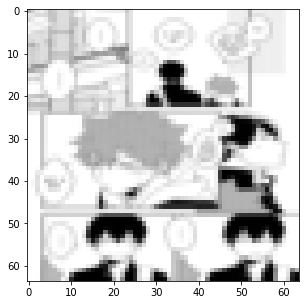

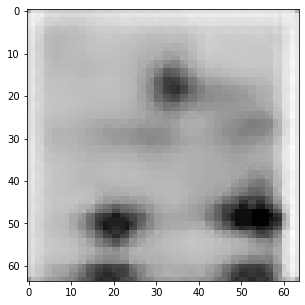

In [278]:
def prop(model, img):
    out = model(img.unsqueeze(0).unsqueeze(0))
    return out.detach().numpy()[0][0]
    
# getting the image from train dataset
img = train_data[26][20][0]

# getting the reconstructed version of image
recon = prop(model, img)

# show the initial image
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.show()

# showing the reconstructed image
plt.figure(figsize=(5, 5))
plt.imshow(recon, cmap='gray')
plt.show()

In [276]:
torch.save(model, 'model.pt')